In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [66]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf


In [67]:
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True # dynamically grow the memory used on the GPU
config.log_device_placement = True # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
%matplotlib inline

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GRID A100D-80C, pci bus id: 0000:02:02.0, compute capability: 8.0



2023-11-07 05:38:54.616025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 05:38:54.616537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 05:38:54.616666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [68]:
my_data_dir = 'dataset/cell_images'

In [69]:
os.listdir(my_data_dir)

['test', 'train']

In [70]:
test_path = my_data_dir+'/test/'
train_path = my_data_dir+'/train/'

In [71]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [72]:
len(os.listdir(train_path+'/uninfected/'))

12479

In [73]:
len(os.listdir(train_path+'/parasitized/'))

12479

In [74]:
os.listdir(train_path+'/parasitized')[7]

'C116P77ThinF_IMG_20150930_171954_cell_94.png'

In [75]:
para_img= imread(train_path+
                 '/parasitized/'+
                 os.listdir(train_path+'/parasitized')[7])

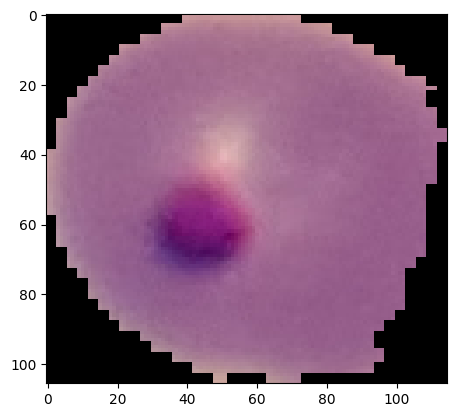

In [76]:
plt.imshow(para_img)

In [77]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'/uninfected'):
    img = imread(test_path+'/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

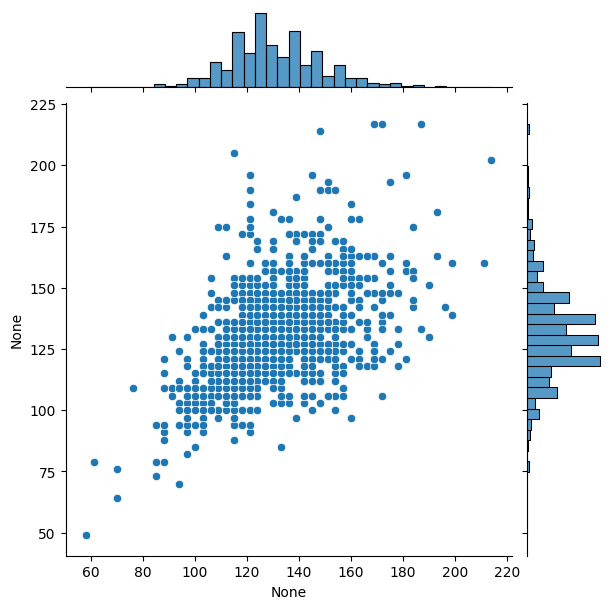

In [78]:
sns.jointplot(x=dim1,y=dim2)

In [79]:
image_shape = (130,130,3)

In [80]:
#help(ImageDataGenerator)

In [81]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [82]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [83]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [84]:
model = models.Sequential()
model.add(layers.Input(shape=(130,130,3))) 
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation='relu'))
model.add(layers.AvgPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(32,activation='relu')) 
model.add(layers.Dense(1, activation ='sigmoid'))
model.summary()
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 130, 130, 32)      896       
                                                                 
 average_pooling2d_2 (Avera  (None, 65, 65, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 65, 65, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 32)               

In [85]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 130, 130, 32)      896       
                                                                 
 average_pooling2d_2 (Avera  (None, 65, 65, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 65, 65, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 32)               

In [86]:
batch_size = 16

In [87]:
#help(image_gen.flow_from_directory)

In [88]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [89]:
train_image_gen.batch_size

16

In [90]:
len(train_image_gen.classes)

24958

In [91]:
train_image_gen.total_batches_seen

0

In [92]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [93]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [95]:
results = model.fit(train_image_gen,epochs=2,
validation_data=test_image_gen )

Epoch 1/2


2023-11-07 05:40:10.991170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 458.19MiB (480444416 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-11-07 05:40:10.994423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 458.19MiB (480444416 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-11-07 05:40:10.997612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 458.19MiB (480444416 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-11-07 05:40:21.045950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-07 05:40:21.109314: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f00e5823530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-07 05:40:21.109348: I tensorflo

1560/1560 [==============================] - 135s 79ms/step - loss: 0.4145 - accuracy: 0.8108 - val_loss: 0.3438 - val_accuracy: 0.8712
Epoch 2/2
1560/1560 [==============================] - 121s 77ms/step - loss: 0.2319 - accuracy: 0.9230 - val_loss: 0.2297 - val_accuracy: 0.9185


In [96]:
losses = pd.DataFrame(model.history.history)

<Axes: >

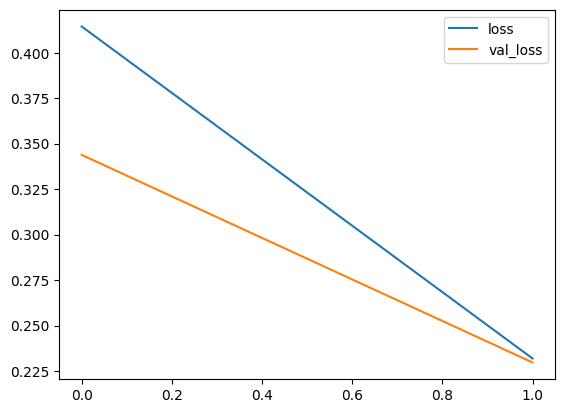

In [97]:
losses[['loss','val_loss']].plot()

In [98]:
model.metrics_names

['loss', 'accuracy']

In [99]:
model.evaluate(test_image_gen)

163/163 [==============================] - 12s 74ms/step - loss: 0.2307 - accuracy: 0.9177


[0.23074965178966522, 0.9176923036575317]

In [100]:
pred_probabilities = model.predict(test_image_gen)

163/163 [==============================] - 12s 73ms/step


In [112]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [113]:
predictions = pred_probabilities > 0.5

In [114]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1300
           1       0.93      0.91      0.92      1300

    accuracy                           0.92      2600
   macro avg       0.92      0.92      0.92      2600
weighted avg       0.92      0.92      0.92      2600



In [115]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1208,   92],
       [ 121, 1179]])

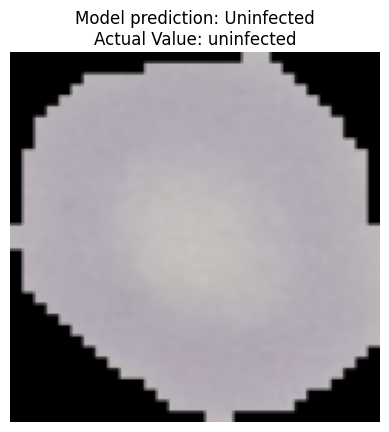

In [120]:
plt.title("Model prediction: "+("Parasitized" if pred  else "Uninfected")+"\nActual Value: "+str(dir_))
plt.axis("off")
plt.imshow(img)
plt.show()
